# Importing packages

## Setup

In [2]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import open3d
import pptk
from logging import raiseExceptions
import seaborn as sns
import funcs
import tensorflow as tf

%reload_ext funcs


## Data loader

original dataframe size (1066, 18)
 dataframe (688, 4)


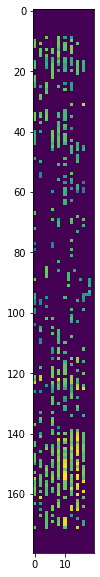

In [198]:
dataloader = funcs.DataLoader(modality='Radar' , data_type='matrix')
dataloader.get_data(filename='1_.txt')

print('original dataframe size', dataloader.dataframe_original.shape)
print(' dataframe',  dataloader.dataframe.shape )

plt.figure(figsize=(50,10))
plt.imshow(dataloader.data_matrix.T / dataloader.data_matrix.max() )

In [199]:
x,y,z = funcs.spherical_to_cartesian( Azimuth_Angle=dataloader.dataframe.Azimuth , Elevation_Angle=dataloader.dataframe.Elevation - 10 , Range=dataloader.dataframe.Range )

# plt.hist(z)

dataloader.dataframe

,Range,Azimuth,Elevation,RCS
0,1,31,16,85
1,1,54,2,43
2,1,55,2,41
3,1,56,8,40
6,1,57,16,41
...,...,...,...,...
1059,485,40,2,56
1060,496,44,0,61
1061,497,47,12,63
1063,499,46,16,62


In [200]:
# dataloader.dataframe_original

## <span style="color:orange; font-size:0.8em"> Viewing the point clouds </span>

In [196]:
columns = dataloader.dataframe.columns[:3]

funcs.DataLoader().visualize(points=dataloader.dataframe[columns])

## <span style="color:orange; font-size:0.8em"> Vector Input </span>

In [129]:
# vector_input = funcs.VectorInput(filename='1_.txt', modality='Radar', normalize=True)

# vector_input.prediction

## <span style="color:orange; font-size:0.8em"> Matrix Input </span>

In [25]:
# vector_input.view()
vector_input.dataframe

import tensorflow as tf 

# tensorflow dataset from dataframe
dataset = tf.data.Dataset.from_tensor_slices(vector_input.dataframe)

# normalize the data in each column to 0-1
dataset = dataset.map(lambda x: (x - tf.math.reduce_min(x)) / (tf.math.reduce_max(x) - tf.math.reduce_min(x)))


# view the values in dataset
for x in dataset.take(1):
    print(x)

tf.Tensor([0.         0.20074569 0.9367698  0.21696949 1.         0.58504146], shape=(6,), dtype=float64)


In [15]:
# view the values in dataset
for x in dataset.take(1):
    print(x)

tf.Tensor([0.         0.20074569 0.9367698  0.21696949 1.         0.58504146], shape=(6,), dtype=float64)


In [5]:
vector_input.data.train

,Range,Azimuth,Elevation,Amplitude,RCS,Velocity
31,0.001,0.936111,0.5,0.22173,0.869165,0.500
807,0.182,0.836111,0.6,0.01533,0.637108,0.410
413,0.025,0.547222,0.2,0.00461,0.532740,0.655
1025,0.319,0.550000,0.6,0.02098,0.664361,0.500
798,0.180,0.813889,0.8,0.03205,0.701166,0.775
...,...,...,...,...,...,...
868,0.206,0.869444,0.3,0.02543,0.681069,0.225
908,0.228,0.813889,0.7,0.08697,0.787874,0.500
50,0.002,0.191667,0.1,0.02744,0.687677,0.500
353,0.019,0.533333,0.8,0.00621,0.558618,0.420


## <span style="color:orange; font-size:0.8em"> Matrix Input </span>

In [6]:
matrix_input = funcs.MatrixInput(dataset_directory='/home/artin/Documents/10dB_CR_10deg_in_2021-10-15-14-15-49' , modality='Radar')

matrix_input.data.full.shape

(180, 20)

In [20]:
matrix_input.data.full.sum()

57787.0

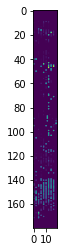

In [8]:
plt.imshow(matrix_input.data.full)
plt.show()